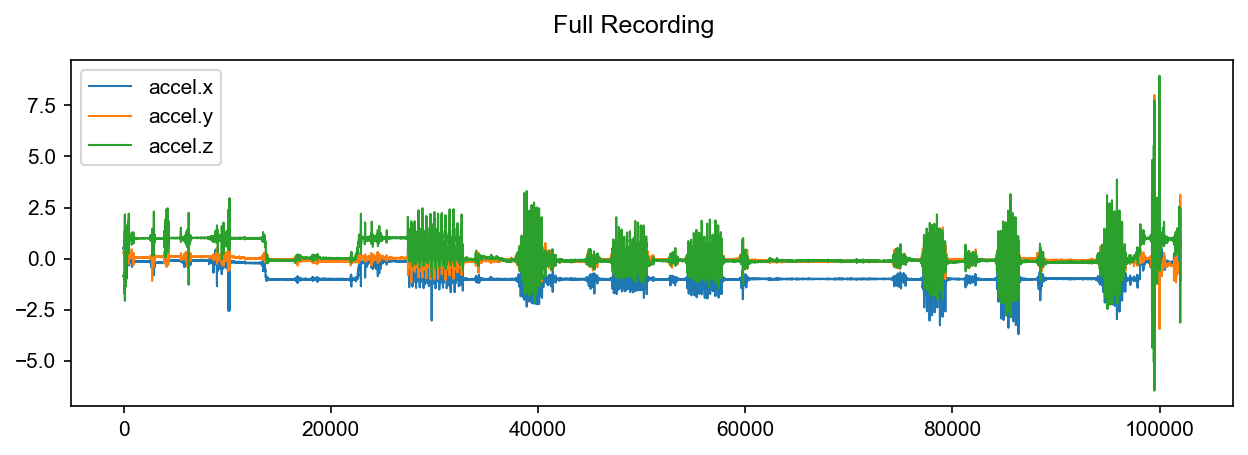

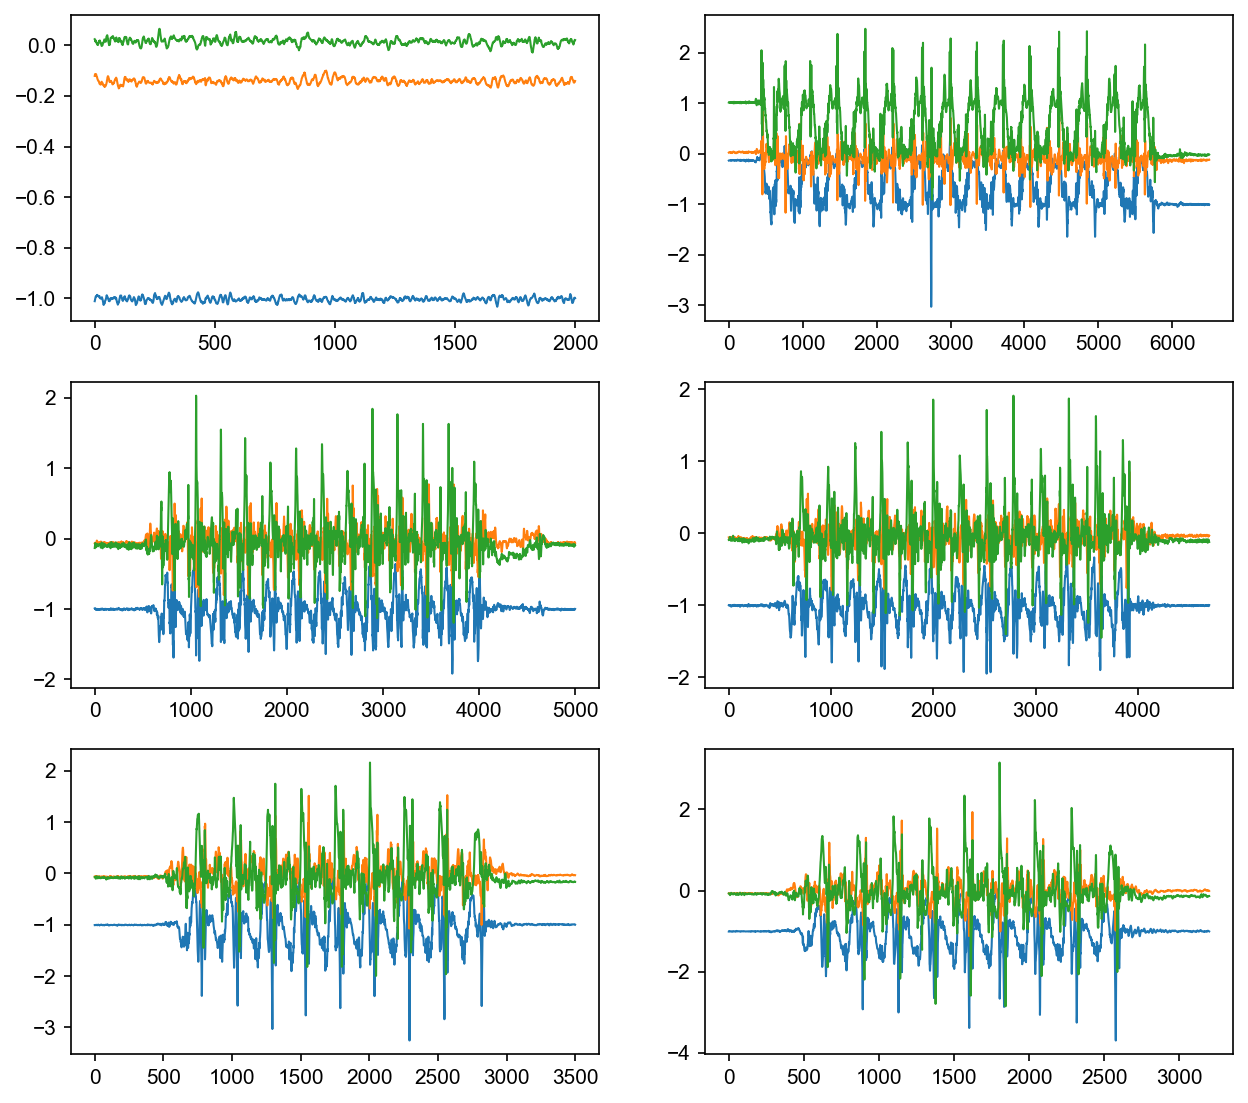

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'

from orientation import *
from signal_processing import *
from ahrs.common import Quaternion

fs = 208

# Crop the trials
imu = pd.read_csv('./data/ANNE/Static_30CST_4xWalk_Right_Thigh_imu.csv')
fig, ax = plt.subplots(figsize=(10,3), dpi=150)
fig.suptitle('Full Recording')
imu.iloc[:, 1:4].plot(ax=ax, lw=1)
plt.show()

static = imu.iloc[19000:21000, 1:].to_numpy()
cst_30 = imu.iloc[27000:33500, 1:].to_numpy()
wt_c1 = imu.iloc[46500:51500, 1:].to_numpy()
wt_c2 = imu.iloc[53800:58500, 1:].to_numpy()
wt_s1 = imu.iloc[76500:80000, 1:].to_numpy()
wt_s2 = imu.iloc[83800:87000, 1:].to_numpy()

fig, ax = plt.subplots(3, 2, figsize=(10, 9), dpi=150)
# Static
ax[0,0].plot(static[:, :3], lw=1)
ax[0,1].plot(cst_30[:, :3], lw=1)
ax[1,0].plot(wt_c1[:, :3], lw=1)
ax[1,1].plot(wt_c2[:, :3], lw=1)
ax[2,0].plot(wt_s1[:, :3], lw=1)
ax[2,1].plot(wt_s2[:, :3], lw=1)
plt.show()

np.save('./data/ANNE/Static.npy', static)
np.save('./data/ANNE/CST30.npy', cst_30)
np.save('./data/ANNE/Walk_Test_Constrained_1.npy', wt_c1)
np.save('./data/ANNE/Walk_Test_Constrained_2.npy', wt_c2)
np.save('./data/ANNE/Walk_Test_SelfSelected_1.npy', wt_s1)
np.save('./data/ANNE/Walk_Test_SelfSelected_2.npy', wt_s2)

## Trials Start Here

- Accelerometer is in [g]
- Gyroscope is in [deg]

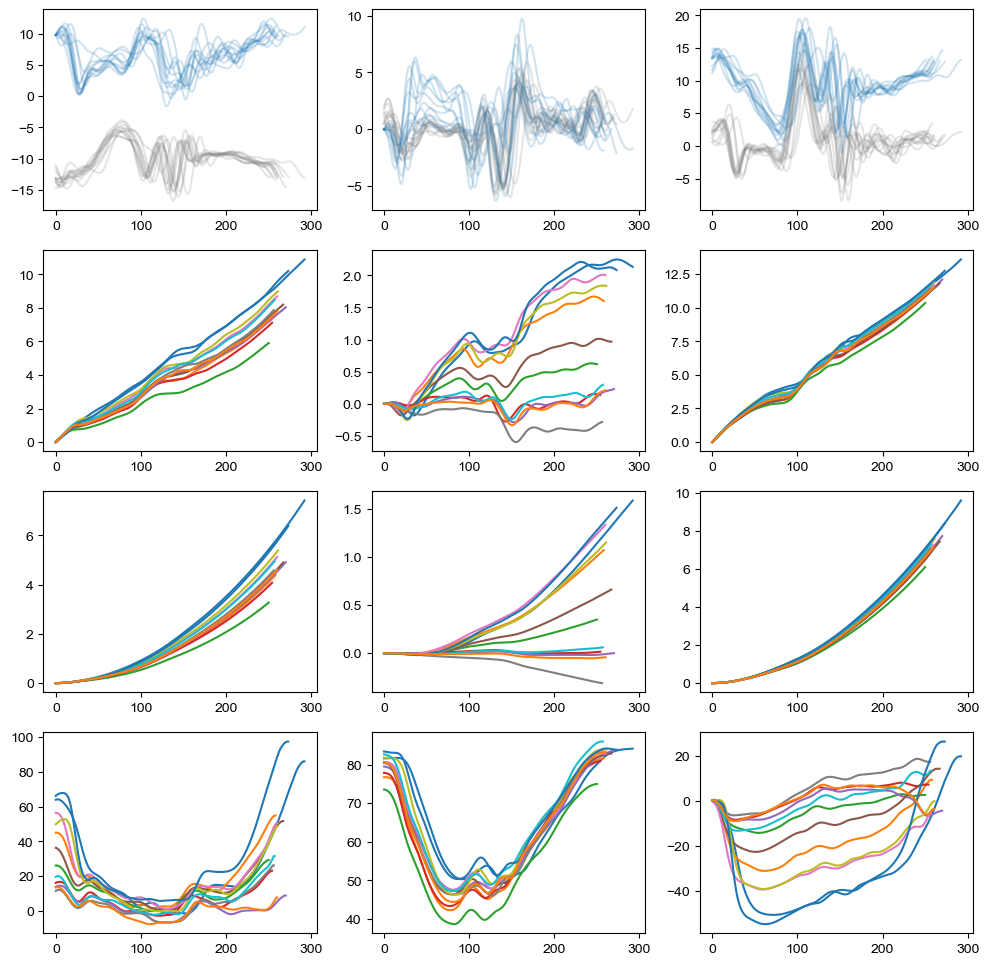

In [274]:
from scipy.signal import find_peaks

static = np.load('./data/ANNE/Static.npy')
wt_c1 = np.load('./data/ANNE/Walk_Test_Constrained_1.npy')

#g_sensor = np.mean(static[:, :3], axis=0)
g_sensor = np.mean(wt_c1[:fs, :3], axis=0)
g_global = detect_ideal_gravity(g_sensor)
R = rodrigues_rotation(g_sensor, g_global)
w_bias = np.radians(np.mean(wt_c1[:fs, 3:], axis=0))


acc = wt_c1[:, :3]
gyr = np.radians(wt_c1[:, 3:]) - w_bias

a_m = bwfilt((R @ acc.T).T, 4, 10, fs)
w_m = bwfilt((R @ gyr.T).T, 4, 10, fs)

# Detection of gait events #
w_ml = bwfilt(-w_m[:, 1], 4, 5, fs)
pks, _ = find_peaks(w_ml, height=np.quantile(w_ml, q=.85), distance=int(0.5*fs))

ge = []
for p in pks:
    for k in range(p, 1, -1):
        if w_m[k, 1] * w_m[k-1, 1] < 0:
            ge.append(k-1)
            break     

# Create breaks (strides)
breaks = []
for i in range(0, len(ge)-1):
    breaks.append((ge[i], ge[i+1]-1))



sl = []
fig, (axa, axv, axd, axt) = plt.subplots(4, 3, figsize=(12,12))
for i, (ti, tf) in enumerate(breaks):
    a_m_stride, w_m_stride = a_m[ti:tf, :]*9.81, w_m[ti:tf, :]
   
    # Compute overall orientation over time
    mad = Madgwick(gyr=w_m_stride, acc=a_m_stride, frequency=fs)
    q = mad.Q # Orientation quaternion
    
    # Initialize acceleration of the inertial frame
    a_I = np.zeros_like(a_m_stride)

    angles = np.zeros_like(a_m_stride)
    for k in range(len(q)):
        angles[k] = np.degrees(Quaternion(q[k]).to_angles())

    R_IB = DCM().from_quaternion(q=q)

    for k in range(R_IB.shape[0]):
        a_I[k] = (R_IB[k] @ a_m_stride[k]) - np.array([-9.81, 0, 0])

    # a_I -= a_I[0]
    v_I = integrate_ndim(a_I, fs=fs)
    d_I = integrate_ndim(v_I, fs=fs)

    axa[0].plot(a_I[:,0], c='C0', alpha=.2)
    axa[0].plot(a_m_stride[:,0], c='grey', alpha=.2)
    axa[1].plot(a_I[:,1], c='C0', alpha=.2)
    axa[1].plot(a_m_stride[:,1], c='grey', alpha=.2)
    axa[2].plot(a_I[:,2], c='C0', alpha=.2)
    axa[2].plot(a_m_stride[:,2], c='grey', alpha=.2)

    axv[0].plot(v_I[:,0])
    axv[1].plot(v_I[:,1])
    axv[2].plot(v_I[:,2])

    axd[0].plot(d_I[:,0])
    axd[1].plot(d_I[:,1])
    axd[2].plot(d_I[:,2])

    axt[0].plot(angles[:,0])
    axt[1].plot(angles[:,1])
    axt[2].plot(angles[:,2])

plt.show()

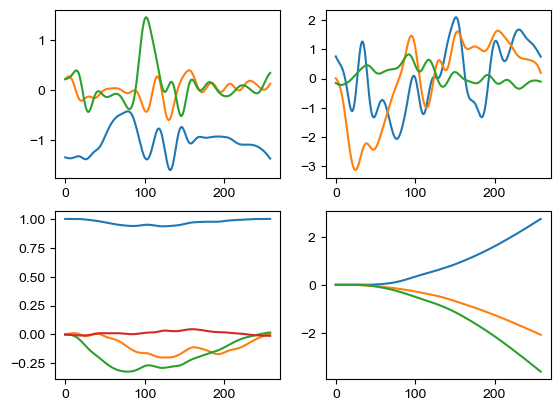

In [293]:
#plt.plot(w_m)
#plt.plot(ge, w_m[ge, 1], 'xr')

from ahrs.filters import Tilt, AngularRate

for i, (ti, tf) in enumerate(breaks[1:2]):
    a_m_stride, w_m_stride = a_m[ti:tf], w_m[ti:tf]
    _, (ax1, ax2) = plt.subplots(2, 2)
    ax1[0].plot(a_m_stride)
    ax1[1].plot(w_m_stride)

    tilt = Tilt()
    q_initial = tilt.estimate(acc=a_m_stride[0])
    AngularRate = AngularRate(gyr=w_m_stride, q0=q_initial, frequency=fs)

    R_IB = DCM().from_quaternion(q=AngularRate.Q)

    # Initialize acceleration of the inertial frame
    a_I = np.zeros_like(a_m_stride)
    for k in range(R_IB.shape[0]):
        a_I[k] = (R_IB[k] @ a_m_stride[k]) - a_m_stride[0]

    v_I = integrate_ndim(a_I * 9.81, fs=fs)
    ax2[0].plot(AngularRate.Q)
    ax2[1].plot(integrate_ndim(v_I, fs=fs))

    
    


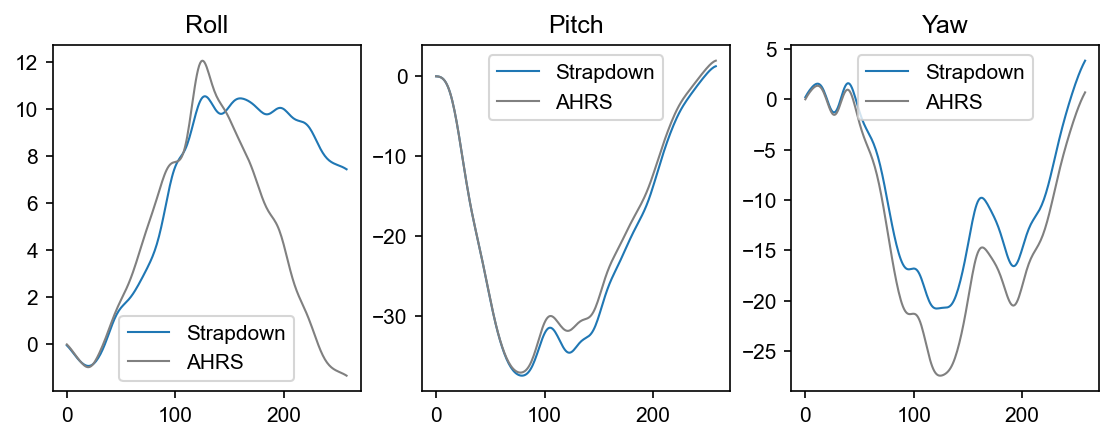

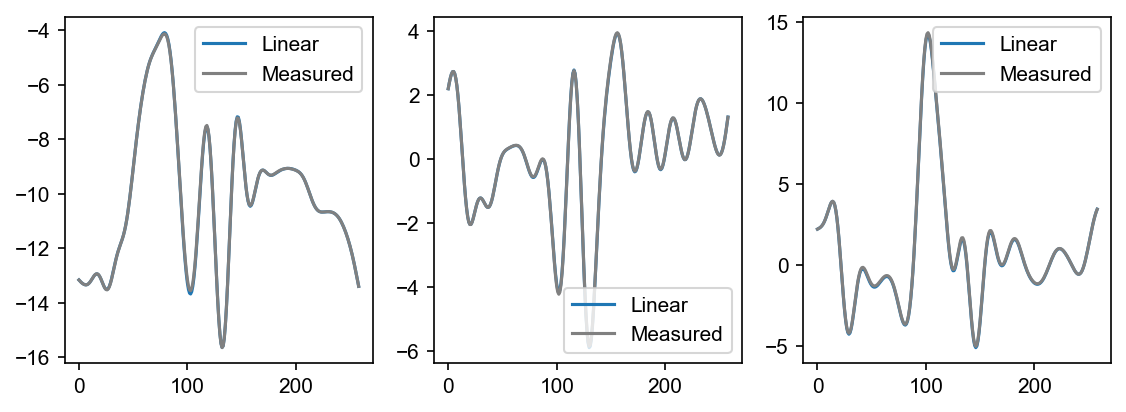

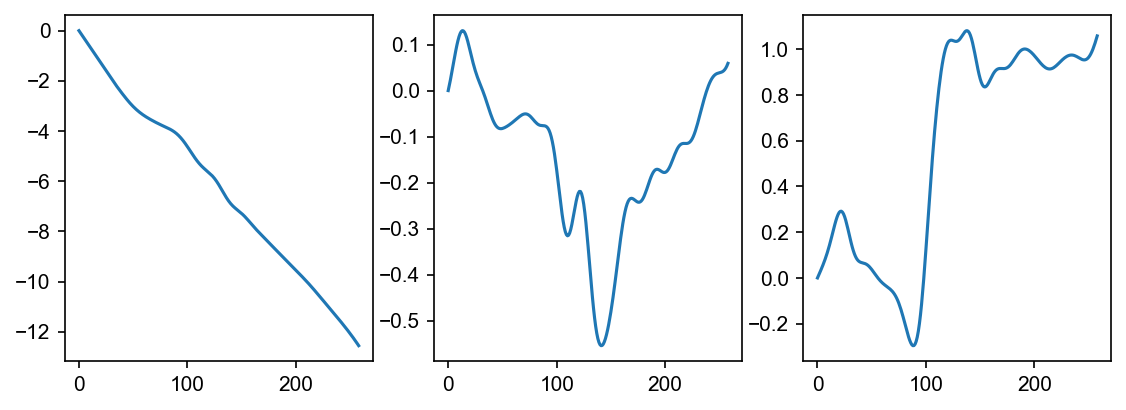

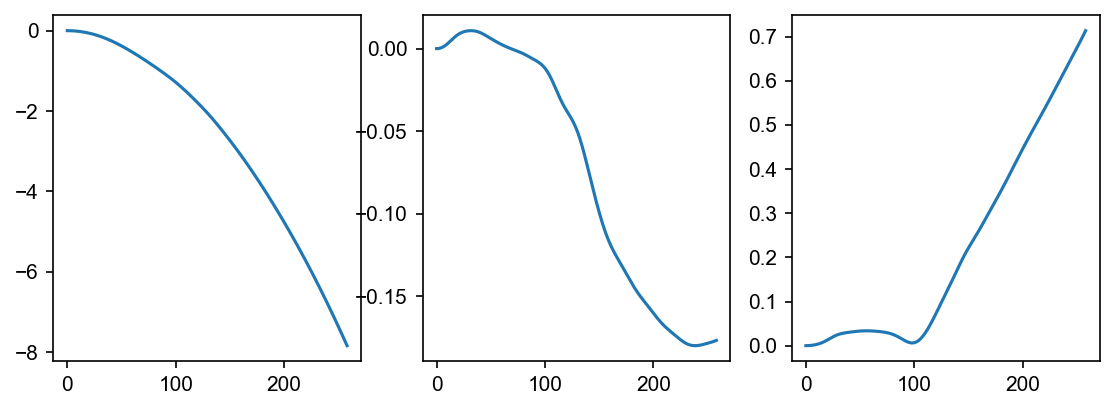

In [ ]:
from ahrs.filters.angular import AngularRate
from ahrs.common import Quaternion

# Manual calculation
angles = np.cumsum(w_m_stri de * 1/fs, axis=0)
r, p, y = angles[:, 2], angles[:, 1], angles[:, 0]

# Computation via Filter
AngularRate = AngularRate(gyr=w_m_stride, q0=np.array([1., 0., 0., 0.]), frequency=fs)
q_ahrs = AngularRate.Q
rpy_ahrs = np.zeros((len(q_ahrs), 3))
for k, qk in enumerate(q_ahrs):
    rpy_ahrs[k] = Quaternion(qk).to_angles()

r_ahrs, p_ahrs, y_ahrs = rpy_ahrs[:, 2], rpy_ahrs[:, 1], rpy_ahrs[:, 0]

_, ax = plt.subplots(1, 3, figsize=(9,3), dpi=150)
ax[0].plot(np.degrees(r), label='Strapdown', c='C0', lw=1)
ax[0].plot(np.degrees(rpy_ahrs[:, 2]), label='AHRS', c='grey', lw=1)
ax[0].set_title('Roll')

ax[1].plot(np.degrees(p), label='Strapdown', c='C0', lw=1)
ax[1].plot(np.degrees(rpy_ahrs[:, 1]), label='AHRS', c='grey', lw=1)
ax[1].set_title('Pitch')

ax[2].plot(np.degrees(y), label='Strapdown', c='C0', lw=1)
ax[2].plot(np.degrees(rpy_ahrs[:, 0]), label='AHRS', c='grey', lw=1)
ax[2].set_title('Yaw')

ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

swap = rpy_ahrs.copy()
swap[:, [0, 2]] = swap[:, [2, 0]]

a_I = np.zeros_like(a_m_stride)
for k, rpy in enumerate(swap):
    R_IB = DCM(rpy=rpy)
    a_I[k] = R_IB @ a_m_stride[k] *9.81

_, ax = plt.subplots(1, 3, figsize=(9,3), dpi=150)
ax[0].plot(a_I[:, 0], label='Linear', color='C0')
ax[0].plot(a_m_stride[:, 0] * 9.81, label='Measured', color='grey')
ax[1].plot(a_I[:, 1], label='Linear', color='C0')
ax[1].plot(a_m_stride[:, 1] * 9.81, label='Measured', color='grey')
ax[2].plot(a_I[:, 2], label='Linear', color='C0')
ax[2].plot(a_m_stride[:, 2] * 9.81, label='Measured', color='grey')
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

v_I = integrate_ndim(a_I, fs=fs)
d_I = integrate_ndim(v_I, fs=fs)

_, ax = plt.subplots(1, 3, figsize=(9,3), dpi=150)
ax[0].plot(v_I[:, 0])
ax[1].plot(v_I[:, 1])
ax[2].plot(v_I[:, 2])
plt.show()

_, ax = plt.subplots(1, 3, figsize=(9,3), dpi=150)
ax[0].plot(d_I[:, 0])
ax[1].plot(d_I[:, 1])
ax[2].plot(d_I[:, 2])
plt.show()


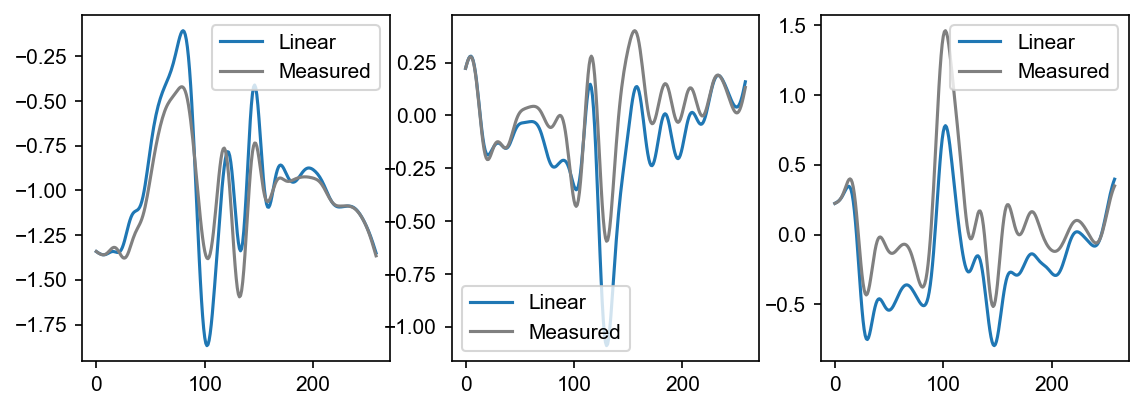

In [373]:
def rpy_to_DCM(x=None, order=[2,1,0]):
    # R = RYaw @ RPitch @ RRoll
    R, P, Y = order

    RYaw = np.array([[1, 0, 0],
                     [0, np.cos(x[Y]), -np.sin(x[Y])],
                     [0, np.sin(x[Y]), np.cos(x[Y])]])
    
    RPitch = np.array([[np.cos(x[P]), 0, np.sin(x[P])],
                       [0, 1, 0],
                       [-np.sin(x[P]), 0, np.cos(x[P])]])

    RRoll = np.array([[np.cos(x[R]), -np.sin(x[R]), 0],
                      [np.sin(x[R]), np.cos(x[R]), 0],
                      [0, 0, 1]])

    R = RYaw @ RPitch @ RRoll

    return R

rpy_fake_yaw = rpy_ahrs.copy()
#rpy_fake_yaw[:, 0] = 0

a_I = np.zeros_like(a_m_stride)
for k, a in enumerate(a_m_stride):
    R = rpy_to_DCM(x=rpy_fake_yaw[k,:])
    a_I[k] = R @ a

_, ax = plt.subplots(1, 3, figsize=(9,3), dpi=150)
ax[0].plot(a_I[:, 0], label='Linear', color='C0')
ax[0].plot(a_m_stride[:, 0], label='Measured', color='grey')
ax[1].plot(a_I[:, 1], label='Linear', color='C0')
ax[1].plot(a_m_stride[:, 1], label='Measured', color='grey')
ax[2].plot(a_I[:, 2], label='Linear', color='C0')
ax[2].plot(a_m_stride[:, 2], label='Measured', color='grey')
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

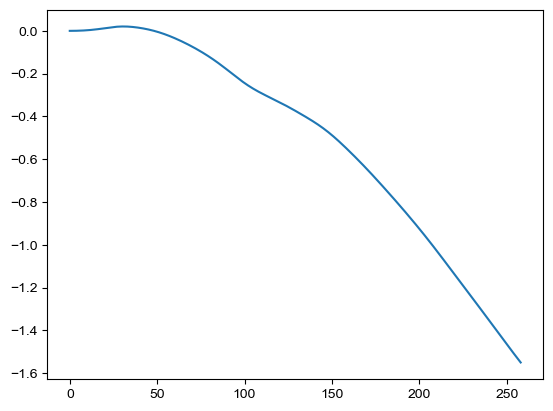

In [377]:
plt.plot(integrate_ndim(integrate_ndim(a_I[:, 2] * 9.81, fs=fs), fs=fs))